# ANHA4-EXH005 Sea-ice v.s. Remote Sensing data

* This notebook is a comparison between ANHA4 and SSM/I retrival sea-ice cover at Beaufort Sea.
* The comparison result explains the over estimation of d18O. 

Data source: http://nsidc.org/data/docs/noaa/g02202_ice_conc_cdr/index.html#data_description

In [1]:
import sys
sys.path.insert(0, '../../_libs/')

In [2]:
import glob
import scipy.io
import datetime
import numpy as np
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
% matplotlib inline

In [3]:
def interp_np(xin, yin, zin, xout, yout, key=1):
    if key==1:
        zin2 = np.copy(zin)
        zin2[np.isnan(zin)]=0.0
    else:
        zin2 = zin
    zout = Nts.reporj_NEMOgrid(xin, yin, zin2, xout, yout, method='linear')
    zfill = Nts.reporj_NEMOgrid(xin, yin, zin2, xout, yout, method='nearest')
    zout[np.isnan(zout)] = zfill[np.isnan(zout)]

In [4]:
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

In [6]:
MAT = scipy.io.loadmat('../../_data/Mask files/vdt_BG_mask.mat')
vdt_mask = MAT['mask_ANHA4'][:]

In [7]:
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
deptht = coordinate_obj.variables['nav_lev'][:]
e1t = coordinate_obj.variables['e1t'][:]
e2t = coordinate_obj.variables['e2t'][:]
e3t = coordinate_obj.variables['e3t_0'][:]

In [8]:
ice_name = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/ileadfra_monmean.nc'
time_list = [19, 31, 43, 55, 67, 79]
ice_obj = nc.Dataset(ice_name)
ANHA4_ice = ice_obj.variables['ileadfra'][12:84, :, :]

In [10]:
nsidc_name = sorted(glob.glob('../../_data/Remote/NSIDC_Sea-ice/*.nc'))
ice_obj = nc.Dataset(nsidc_name[0])
nsidc_lon = ice_obj.variables['longitude'][:]
nsidc_lat = ice_obj.variables['latitude'][:]

In [12]:
nsidc_lat.shape

(448, 304)

In [11]:
nsidc_bt_ice = np.zeros([72, 448, 304])
nsidc_nt_ice = np.zeros([72, 448, 304])

for i in range(72):
    ice_obj = nc.Dataset(nsidc_name[i])
    nsidc_bt_ice[i, :, :] = ice_obj.variables['goddard_bt_seaice_conc_monthly'][:]
    nsidc_nt_ice[i, :, :] = ice_obj.variables['goddard_nt_seaice_conc_monthly'][:]

In [47]:
vdt_mask_regrid = Nts.reporj_NEMOgrid(nav_lon, nav_lat, vdt_mask, nsidc_lon, nsidc_lat, method='nearest')

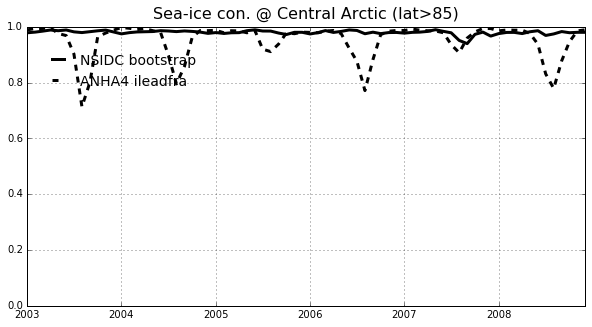

In [30]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca(); ax.grid()
ax.set_ylim([0, 1.0])
ax.plot(date_list[12:84], np.nanmean(nsidc_bt_ice[:, (nsidc_lat>85)&(nsidc_lat<87)], 1), 'k-', lw=3, label='NSIDC bootstrap' )
ax.plot(date_list[12:84], np.nanmean(ANHA4_ice[:, (nav_lat>85)&(nav_lat<87)], 1), 'k--', lw=3, label='ANHA4 ileadfra' )
LG = ax.legend(bbox_to_anchor=(0.325, 0.95), prop={'size':14}, handlelength=1.5); LG.draw_frame(False)
ax.set_title('Sea-ice con. @ Central Arctic (lat>85)', fontsize=16, y=1.01)

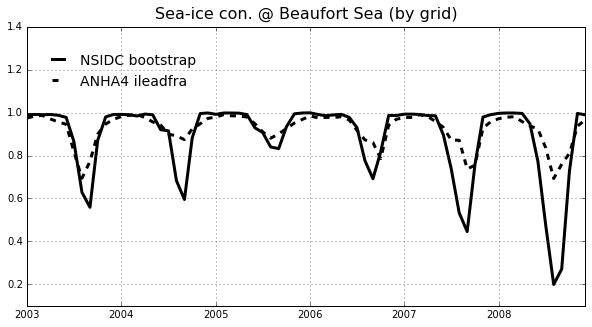

In [90]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca(); ax.grid()
ax.set_ylim([0.1, 1.4])
ax.plot(date_list[12:84], np.nanmean(nsidc_bt_ice[:, vdt_mask_regrid==1], 1), 'k-', lw=3, label='NSIDC bootstrap' )
ax.plot(date_list[12:84], np.nanmean(ANHA4_ice[:, vdt_mask==1], 1), 'k--', lw=3, label='ANHA4 ileadfra' )
LG = ax.legend(bbox_to_anchor=(0.325, 0.95), prop={'size':14}, handlelength=1.5); LG.draw_frame(False)
ax.set_title('Sea-ice con. @ Beaufort Sea (by grid)', fontsize=16, y=1.01)

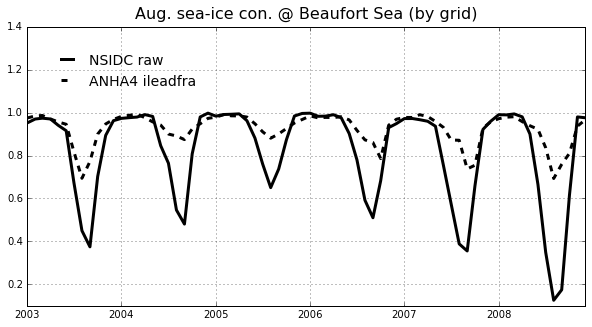

In [92]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca(); ax.grid()
ax.set_ylim([0.1, 1.4])
ax.plot(date_list[12:84], np.nanmean(nsidc_nt_ice[:, vdt_mask_regrid==1], 1), 'k-', lw=3, label='NSIDC raw' )
ax.plot(date_list[12:84], np.nanmean(ANHA4_ice[:, vdt_mask==1], 1), 'k--', lw=3, label='ANHA4 ileadfra' )
LG = ax.legend(bbox_to_anchor=(0.325, 0.95), prop={'size':14}, handlelength=1.5); LG.draw_frame(False)
ax.set_title('Aug. sea-ice con. @ Beaufort Sea (by grid)', fontsize=16, y=1.01)

# ~~Conclusion~~

* ~~ANHA4-EXH005 has **more** Sea ice during the summer, and **less** Sea-ice in fall-winter.~~
* ~~In the model, the ice formation amount is less than the data, so less oxygen-18 goes into the sea-ice in winter-spring.~~
* ~~Therefore, d18O in Beaufort Sea is overestimated.~~

# Things known

(1) d18O initial field [Schmidt et al., 1999] has high vals in Beaufort Sea (comparing with BGEP obs in 2003-2005).

(2) The tracer model set sea-ice melt end-member val. as 1.5, which is good for the central Arctic, Fram strait but an overestimation in Canada Basin.

(3) ANHA4-EXH004 has less sea-ice melt/formation cycle comparing with remote sensing data.

** An overview of related research **

|Region       |Sea-ice melt d18O end-member|Reference|
|-------------|---------|-----------------------|
| Bering-Fram transect | $\mathrm{+2.6\pm0.1}$  | Ekwurzel et al (2001) |
| Nansen, Fram, Barents Sea| $\mathrm{+3.0}$, but surface sample val plus $\mathrm{1.5}$ | Östlund & Hut (1984) |
| L-Ridge, Nansen Basin | $\mathrm{+2.5}$+sample val, close to $\mathrm{+1.5}$ | Bauch et al. (1995) |
| Laptev Sea           | $\mathrm{+2.6}$, *Ekwurzel et al (2001) cited*       | Rosén et al (2015)    |
| Canada Basin         | $\mathrm{-2.0\pm0.1}$ | Macdonald et al (2002) |
| Canada Basin         | $\mathrm{-2.0\pm1.0}$ | Yamamoto‐Kawai et al (2008) |
| pan-Arctic (everywhere) | $\mathrm{+0.2+-1}$     | Yamamoto‐Kawai et al (2005) |


In Yamamoto‐Kawai et al. (2008):
<img src="../../_figures/YK_Fig2.PNG" width="500" align="center"/>
In Eicken et al. (2002): 
> *(In Canada Basin)* Even toward the end of summer such meltwater still contained significant fractions of meteoric water (36% for the core shown in Figure 6, compared to a 20% meteoric fraction of total surface melt), indicating a compartmentalization and lack of mixing of the meltwater reservoir ...

**It seems that sea-ice melt water in Canada Basin has lower d18O end-member val. than other Arctic basins.**


## Reference

Ekwurzel, B., et al.  (2001) River runoff, sea ice meltwater, and Pacific water distribution and mean residence times in the Arctic Ocean. Journal of Geophysical Research: Oceans **106**(C5): 9075-9092.

Östlund, H. Göte, and Gert Hut. (1984) Arctic Ocean water mass balance from isotope data. Journal of Geophysical Research: Oceans **89**(C4): 6373-6381.

Bauch, D. et al. (1995) Freshwater balance and the sources of deep and bottom waters in the Arctic Ocean inferred from the distribution of H218O. Progress in Oceanography **35**(1): 53-80.

Rosén, P.-O., et al. (2015) Ice export from the Laptev and East Siberian Sea derived from δ18O values. Journal of Geophysical Research: Oceans **120**(9): 5997-6007.

Macdonald, R. W. et al. (2002) Fresh water and its sources during the SHEBA drift in the Canada Basin of the Arctic Ocean. Deep Sea Research Part I: Oceanographic Research Papers **49**(10): 1769-1785.

Yamamoto‐Kawai, M. et al. (2005) Freshwater and brine behaviors in the Arctic Ocean deduced from historical data of δ18O and alkalinity (1929–2002 AD). Journal of Geophysical Research: Oceans **110**(C10).

Yamamoto‐Kawai, M., et al. (2008) Freshwater budget of the Canada Basin, Arctic Ocean, from salinity, δ18O, and nutrients. Journal of Geophysical Research: Oceans **113**(C1).

Eicken, H., et al. (2002) Tracer studies of pathways and rates of meltwater transport through Arctic summer sea ice. Journal of Geophysical Research: Oceans **107**(C10).

# Fix the problem ?

<img src="../../_figures/YK_Fig1.PNG" width="500" align="center"/>